In [1]:
import numpy as np
import pandas as pd
import pyreadstat
import matplotlib.pyplot as plt

Matplotlib is building the font cache; this may take a moment.


### (not necessary) Study Trauma Prearrival Activation Paramenter
Edisposition.24 destination team pre-arrival alert/activation (FACTPCRDESTINATIONTEAM)
> adult trauma or   trauma (general)  or trauma (peds); since 16 may be peds activation in certain hospital)

In [5]:
destination_df.sample()

NameError: name 'destination_df' is not defined

In [7]:
# Create a dictionary for mapping old index values to new ones
index_map = {
    '4224001':'No',
    '4224003':'Yes-Adult Trauma',
    '4224005':'Yes-Cardiac Arrest',
    '4224007':'Yes-Obstetrics',
    '4224009':'Yes-Other',
    '4224011':'Yes-Pediatric Trauma',
    '4224013':'Yes-STEMI',
    '4224015':'Yes-Stroke',
    '4224017':'Yes-Trauma (General)',
    '4224019':'Yes-Sepsis',
    '7701001':'Not Applicable',
    '7701003':'Not Recorded',
}

In [9]:
destination_count = destination_df['eDisposition_24'].value_counts(normalize=True)*100

# Rename the index using the dictionary
destination_count.rename(index=index_map, inplace=True)

destination_count

NameError: name 'destination_df' is not defined

In [ ]:
destination_count = destination_df['eDisposition_24'].value_counts()

# Rename the index using the dictionary
destination_count.rename(index=index_map, inplace=True)

destination_count

In [ ]:
len(destination_df)

### (not necessary) Study Trauma Triage Criteria

In [ ]:
# import einjury_03 (trauma criteria for severe injury)
traumacriteria_df, _ = pyreadstat.read_sas7bdat('/Volumes/Research/GoldenHourData/NEMSISRawFiles/factpcrtraumacriteria.sas7bdat', )

# import einjury_04 (trauma criteria for moderate injury)
pcrinjuryrisk_df, _ = pyreadstat.read_sas7bdat('/Volumes/Research/GoldenHourData/NEMSISRawFiles/factpcrinjuryriskfactor.sas7bdat', )


In [ ]:
traumacriteria_df.sample()

In [ ]:
high_risk = traumacriteria_df['eInjury_03']
high_nonapplicable_idx = (high_risk == '7701001') | (high_risk == '7701003') | (high_risk == '8801015')
high_null_idx = high_risk.isnull()
high_risk_idx = ~(high_nonapplicable_idx | high_null_idx)


In [ ]:
# find cases without moderate risk trauma criteria
moderate_risk = pcrinjuryrisk_df['eInjury_04']
moderate_nonapplicable_idx = (moderate_risk == '7701001') | (moderate_risk == '7701003') | (moderate_risk == '8801015')
moderate_null_idx = moderate_risk.isnull()
moderate_risk_idx = ~(moderate_nonapplicable_idx | moderate_null_idx)

In [ ]:
print("may contain duplications")
print(f"# high risk cases: {len(traumacriteria_df[high_risk_idx])}")
print(f"# moderate risk cases: {len(pcrinjuryrisk_df[moderate_risk_idx])}")

## Inclusion Criteria

Einjury.01- cause of injury (factpcrcauseofinjury)
> cause of injury. include the following icd codes: ICD-10-CM: S00-S99, T07, T14, T20-T28 and T30-T32?

Edisposition.21- type of destination (PUB_PCREVENTS)
> Hospital- ED, hospital (i.e. Folks who were sent to the ED)

EPatient. 15 Age (PUB_PCREVENTS)
> Limit to age ≥16 years (may have to look at epatient age units for "years"

Edisposition.24 destination team pre-arrival alert/activation (FACTPCRDESTINATIONTEAM)
> adult trauma or   trauma (general)  or trauma (peds); since 16 may be peds activation in certain hospital)

EInjury.02: (***state data only***)
> include only patients where code= "blunt" or "penetrating" 
I.e. Exclude burn
Delineate: blunt vs penetrating

Edisposition16: ems transport method (PUB_PCREVENTS)
> Delineate whether air or ground 
Can exclude if water 

Following above should give us patients ≥16 years who were transported by ground or air ambulance to an ED after blunt or penetrating injury, and prompted trauma activation at receiving facilities

### Filter: ICD codes

Based on the following:
- einjury01 > factpcrcauseofinjury.sas7bdat
- esituation09 > factpcrprimarysymptom.sas7bdat
- esituation10 > factpcradditionalsymptom.sas7bdat
- esituation11 > factpcrprimaryimpression.sas7bdat
- esituation12 > factpcrsecondaryimpression.sas7bdat

In [3]:
# list trauma icd code to select
s_icd_code = [f'S{x:02}'for x in range(0,100)]
t_icd_code = ['T07', 'T14', 'T20','T21','T22','T23','T24','T25','T26','T27','T28', 'T30','T31','T32']
trauma_icd_code = s_icd_code + t_icd_code

In [5]:
def icd_filter(df, col_name, trauma_icd_code):
    # break icd codes into primary codes
    df[f'{col_name}_primary'] = df[col_name].apply(lambda x: x[:x.find(".")] if (x.find(".") != -1) else x)
    df[f'{col_name}_secondary'] = df[col_name].apply(lambda x: x[(x.find(".")+1):] if (x.find(".") != -1) else np.nan)

    # find cases that meet prespecified trauma code
    df['meets_code_criteria'] = df[f'{col_name}_primary'].isin(trauma_icd_code)

    print(f"# unique cases reported: {df['PcrKey'].unique().shape}")
    print(f"# cases that meet ICD trauma code: {df.loc[df['meets_code_criteria'], 'PcrKey'].unique().shape}")

In [7]:
# einjury01 - cause of injury
injury_df, _ = pyreadstat.read_sas7bdat('/Volumes/Research/GoldenHourData/NEMSISRawFiles/factpcrcauseofinjury.sas7bdat')

#ICD PICR using einjury_01


icd_filter(injury_df, 'eInjury_01', trauma_icd_code)

# unique cases reported: (54190579,)
# cases that meet ICD trauma code: (171578,)


In [8]:
# esituation09 - primary symptom
primary_sx_df, _ = pyreadstat.read_sas7bdat('/Volumes/Research/GoldenHourData/NEMSISRawFiles/factpcrprimarysymptom.sas7bdat')

icd_filter(primary_sx_df, 'eSituation_09', trauma_icd_code)

# unique cases reported: (53378210,)
# cases that meet ICD trauma code: (1691842,)


In [9]:
# esituation10 - additional symptom
additional_sx_df, _ = pyreadstat.read_sas7bdat('/Volumes/Research/GoldenHourData/NEMSISRawFiles/factpcradditionalsymptom.sas7bdat')

icd_filter(additional_sx_df, 'eSituation_10', trauma_icd_code)

# unique cases reported: (53462643,)
# cases that meet ICD trauma code: (697103,)


In [10]:
# esituation11 - primary impression
primary_imp_df, _ = pyreadstat.read_sas7bdat('/Volumes/Research/GoldenHourData/NEMSISRawFiles/factpcrprimaryimpression.sas7bdat')

icd_filter(primary_imp_df, 'eSituation_11', trauma_icd_code)

# unique cases reported: (52982979,)
# cases that meet ICD trauma code: (4235041,)


In [11]:
# esituation12 - secondary impression
secondary_imp_df, _ = pyreadstat.read_sas7bdat('/Volumes/Research/GoldenHourData/NEMSISRawFiles/factpcrsecondaryimpression.sas7bdat')

icd_filter(secondary_imp_df, 'eSituation_12', trauma_icd_code)

# unique cases reported: (53064818,)
# cases that meet ICD trauma code: (1012799,)


In [12]:
# get unique pcrkey corresponding to trauma icd codes
COI_pcrkey = injury_df.loc[injury_df['meets_code_criteria'], 'PcrKey'].unique().tolist()
primary_sx_pcrkey = primary_sx_df.loc[primary_sx_df['meets_code_criteria'], 'PcrKey'].unique().tolist()
additional_sx_pcrkey = additional_sx_df.loc[additional_sx_df['meets_code_criteria'], 'PcrKey'].unique().tolist()
primary_imp_pcrkey = primary_imp_df.loc[primary_imp_df['meets_code_criteria'], 'PcrKey'].unique().tolist()
secondary_imp_pcrkey = secondary_imp_df.loc[secondary_imp_df['meets_code_criteria'], 'PcrKey'].unique().tolist()

In [13]:
# combine all pcrkey to get one master unique key
# Note shared pcrkey may exist across data
sx_pcrkey = list(set(primary_sx_pcrkey + additional_sx_pcrkey))
imp_pcrkey = list(set(primary_imp_pcrkey + secondary_imp_pcrkey))
final_pcrkey = list(set(COI_pcrkey + sx_pcrkey + imp_pcrkey))

print(f"Final # cases that meet ICD trauma code: {len(final_pcrkey)}")


Final # cases that meet ICD trauma code: 5550218


In [16]:
pd.Series(final_pcrkey, name='PcrKey').to_csv('/Volumes/Research/GoldenHourData/InclusionCriteria/FinalPcrKey.csv', index=False)

### Filter: Age, Destination, Transportation Method


- note: future analysis should note that some cases have multiple injury descriptions

In [18]:
final_pcrkey = pd.read_csv('/Volumes/Research/GoldenHourData/InclusionCriteria/FinalPcrKey.csv')

In [19]:
# edisposition.21, edisposition.15, edisposition.16
disposition_df, _ = pyreadstat.read_sas7bdat('/Volumes/Research/GoldenHourData/NEMSISRawFiles/pub_pcrevents.sas7bdat', 
                                           usecols=["PcrKey", "ePatient_15", "eDisposition_16", "eDisposition_21"])

In [20]:
# merge disposition data to filtered trauma data
trauma_dispo_df = final_pcrkey.merge(disposition_df, left_on='PcrKey', right_on='PcrKey', how='left', validate='1:1')


In [30]:
# filter out age < 16
trauma_dispo_a_df = trauma_dispo_df[trauma_dispo_df['ePatient_15'] >= 16]
print(f"# age (not applicable): {(trauma_dispo_a_df['ePatient_15'] == '7701001').sum()}")
print(f"# age (not recorded): {(trauma_dispo_a_df['ePatient_15'] == '7701003').sum()}")
print(f"# of null age data: {trauma_dispo_df['ePatient_15'].isnull().sum()}")
print(f"# cases < 16 yo: {len(trauma_dispo_df) - len(trauma_dispo_a_df)}")
print(f"# cases >= 16 yo: {len(trauma_dispo_a_df)}")

# age (not applicable): 0
# age (not recorded): 0
# of null age data: 0
# cases < 16 yo: 372835
# cases >= 16 yo: 5177383


In [32]:
# filter for destination of ED or hospital
print(f"# of null destination data: {trauma_dispo_df['eDisposition_21'].isnull().sum()}")

destination_count = trauma_dispo_a_df['eDisposition_21'].value_counts()
# Create a dictionary for mapping old index values to new ones
index_map = {
    "4221001":'Home',
    "4221003":'Hospital-Emergency Department',
    "4221005":'Hospital-Non-Emergency Department Bed',
    "4221007":'Clinic',
    "4221009":'Morgue/Mortuary',
    "4221011": 'Nursing Home/Assisted Living Facility',
    "4221013":'Other',
    "4221015":'Other EMS Responder (air)',
    "4221017":'Other EMS Responder (ground)',
    '4221019':'Police/Jail',
    '4221021':'Urgent Care',
    '4221023':'Freestanding Emergency Department',
    '4221025':'Dialysis Center',
    '4221027':'Diagnostic Services',
    '4221029':'Assisted Living Facility',
    '4221031':'Mental Health Facility',
    '4221033':'Nursing Home',
    '4221035':'Other Recurring Care Center',
    '4221037':'Physical Rehabilitation Facility',
    '4221039':'Drug and/or Alcohol Rehabilitation Facility',
    '4221041':'Skilled Nursing Facility',
    '7701001':'Not Applicable',
    '7701003':'Not Recorded',
}

# Rename the index using the dictionary
destination_count.rename(index=index_map, inplace=True)

destination_count

# of null destination data: 0


eDisposition_21
Hospital-Emergency Department            3552898
Not Applicable                            629697
Not Recorded                              475475
Hospital-Non-Emergency Department Bed     273254
Nursing Home/Assisted Living Facility      80379
Other                                      39270
Other EMS Responder (ground)               31498
Home                                       25533
Freestanding Emergency Department          21760
Clinic                                     20825
Other EMS Responder (air)                  19137
Morgue/Mortuary                             5357
Police/Jail                                 1342
Urgent Care                                  958
Name: count, dtype: int64

In [34]:
dest_idx = (trauma_dispo_a_df['eDisposition_21'] == '4221003') | (trauma_dispo_a_df['eDisposition_21'] == '4221005')
trauma_dispo_ad_df = trauma_dispo_a_df[dest_idx]

print(f"# cases other destination: {len(trauma_dispo_a_df) - len(trauma_dispo_ad_df)}")
print(f"# cases hospital or ED destination: {len(trauma_dispo_ad_df)}")

# cases other destination: 1351231
# cases hospital or ED destination: 3826152


In [36]:
# filter for transportation methods
print(f"# of null transportation data: {trauma_dispo_df['eDisposition_16'].isnull().sum()}")

transportation_count = trauma_dispo_ad_df['eDisposition_16'].value_counts()
# Create a dictionary for mapping old index values to new ones
index_map = {
    "4216001":"Air Medical-Fixed Wing",
    "4216003":"Air Medical-Rotor Craft",
    "4216005":"Ground-Ambulance",
    "4216007":"Ground-ATV or Rescue Vehicle",
    "4216009":"Ground-Bariatric",
    "4216011":"Ground-Other Not Listed",
    "4216013":"Ground-Mass Casualty Bus/Vehicle",
    "4216015":"Ground-Wheelchair Van",
    "4216017":"Water-Boat",
    "7701001":"Not Applicable",
    "7701003":"Not Recorded",
}

# Rename the index using the dictionary
transportation_count.rename(index=index_map, inplace=True)

transportation_count

# of null transportation data: 0


eDisposition_16
Ground-Ambulance                    3596306
Not Recorded                         120046
Air Medical-Rotor Craft               59093
Not Applicable                        26735
Ground-ATV or Rescue Vehicle          11708
Ground-Other Not Listed                6252
Air Medical-Fixed Wing                 4831
Ground-Bariatric                        676
Ground-Mass Casualty Bus/Vehicle        406
Ground-Wheelchair Van                    54
Water-Boat                               45
Name: count, dtype: int64

In [37]:
ground_transport_code = ['4216005', '4216007', '4216009', '4216011', '4216013', '4216015']
air_transport_code = ['4216003']
trans_col = trauma_dispo_ad_df['eDisposition_16']

# find idx with ground or air transport
ground_idx = trans_col.isin(ground_transport_code)
air_idx = trans_col.isin(air_transport_code)

# create column for transport method
trauma_dispo_ad_df['transport_method'] = np.nan
trauma_dispo_ad_df.loc[ground_idx, 'transport_method'] = 'ground'
trauma_dispo_ad_df.loc[air_idx, 'transport_method'] = 'air'

/var/folders/wh/cyttf30j19xf6hc1n4ysxr640000gn/T/ipykernel_1902/3921748740.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trauma_dispo_ad_df['transport_method'] = np.nan
/var/folders/wh/cyttf30j19xf6hc1n4ysxr640000gn/T/ipykernel_1902/3921748740.py:11: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'ground' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  trauma_dispo_ad_df.loc[ground_idx, 'transport_method'] = 'ground'


In [39]:
# filter for only desired ground or air transport code
trauma_dispo_adt_df = trauma_dispo_ad_df[ground_idx | air_idx]

print(f"# cases w/o desired transport: {len(trauma_dispo_ad_df) - len(trauma_dispo_adt_df)}")
print(f"# cases w/ desired transport: {len(trauma_dispo_adt_df)}")

# cases w/o desired transport: 151657
# cases w/ desired transport: 3674495


In [42]:
trauma_dispo_adt_df.to_csv('/Volumes/Research/GoldenHourData/InclusionCriteria/InclusionCriteriaDataWithoutActivation.csv', index=False)

### Exclude population too injured

- remove on scene death (edisposition.12) - pub_pcrevents

In [3]:
trauma_dispo_adt_df = pd.read_csv('/Volumes/Research/GoldenHourData/InclusionCriteria/InclusionCriteriaDataWithoutActivation.csv')

In [4]:
# edisposition.12
disposition_df, _ = pyreadstat.read_sas7bdat('/Volumes/Research/GoldenHourData/NEMSISRawFiles/pub_pcrevents.sas7bdat', 
                                           usecols=["PcrKey", "eDisposition_12"])

# trauma_dispo_adt_df

In [5]:
exclude1_df = trauma_dispo_adt_df.merge(disposition_df, on='PcrKey', how='left', validate='1:1')

In [6]:
index_map = {
    "4212013":'Patient Dead at Scene-No Resuscitation Attempted (With Transport)',
    "4212015":'Patient Dead at Scene-No Resuscitation Attempted (Without Transport)',
    "4212017":'Patient Dead at Scene-Resuscitation Attempted (With Transport)',
    "4212019":'Patient Dead at Scene-Resuscitation Attempted (Without Transport)',
}

print(f"# null edisposition12: {exclude1_df['eDisposition_12'].isnull().sum()}")
eDisposition12_count = exclude1_df['eDisposition_12'].value_counts()

# Rename the index using the dictionary
eDisposition12_count.rename(index=index_map, inplace=True)
eDisposition12_count

# null edisposition12: 0


eDisposition_12
4212033                                                                 3519472
4212031                                                                  115262
4212027                                                                   12227
4212029                                                                    8729
4212025                                                                    7424
4212005                                                                    2723
4212021                                                                    2222
4212023                                                                    2067
4212001                                                                    1685
4212037                                                                     711
4212035                                                                     488
Patient Dead at Scene-No Resuscitation Attempted (Without Transport)        349
4212009                 

In [7]:
# remove all instances of dead at scene
exclude_eDispo12_code = ["4212013", "4212015", "4212017", "4212019"]
eDispos12_remove_idx = exclude1_df['eDisposition_12'].isin(exclude_eDispo12_code)
exclude1_removed_df = exclude1_df[~eDispos12_remove_idx]


In [8]:
print(f"# patients (pre exclusion severe injury): {len(exclude1_df)}")
print(f"# patients (post exclusion severe injury): {len(exclude1_removed_df)}")
print(f"# severe injuries: {len(exclude1_df) - len(exclude1_removed_df)}")

# patients (pre exclusion severe injury): 3674495
# patients (post exclusion severe injury): 3673740
# severe injuries: 755


### exclude population with insignificant injury burden

\(RTS=0.9368\cdot GCS+0.7326\cdot SBP+0.2908\cdot RR\)

- Patients who present with a probability of survival of 36.1% or less are considered severely injured and should be
transported to a Level 1 Trauma Center

- eVitals.19 - Glasgow Coma Score-Eye - FACTPCRVITAL
- eVitals.20 - Glasgow Coma Score-Verbal - FACTPCRVITAL
- eVitals.21 - Glasgow Coma Score-Motor - FACTPCRVITAL
- eVitals.22 - Glasgow Coma Score-Qualifier - PCRVITALGLASGOWQUALIFIERGROUP

- eVitals.06 - SBP (Systolic Blood Pressure) - FACTPCRVITAL

- eVitals.14 - Respiratory Rate - FACTPCRVITAL

In [10]:
vitals_df = pd.read_csv("/Volumes/Research/GoldenHourData/NEMSISRawFiles/factpcrvital_filtered.csv")

In [11]:
vitals_df.sample()

,PcrKey,eVitals_06,eVitals_14,eVitals_02,eVitals_19,eVitals_20,eVitals_21,eVitals_01
39517426,241245605.0,7701001.0,7701001.0,9923001,7701001,7701001,7701001,29MAR2023:15:54:30


In [12]:
print(f"# null vitals: {vitals_df.isnull().any().sum()}")

# null vitals: 0


In [13]:
# find instances where vitals are not applicable, not recorded, or exam not performed
valid_SBP = vitals_df['eVitals_06'] < 1000
valid_RR = vitals_df['eVitals_14'] < 1000
valid_GCS_eye = vitals_df['eVitals_19'] < 10
valid_GCS_verbal = vitals_df['eVitals_20'] < 10
valid_GCS_motor = vitals_df['eVitals_21'] < 10

In [14]:
vitals_remove_invalid_df = vitals_df[valid_SBP & valid_RR & valid_GCS_eye & valid_GCS_verbal & valid_GCS_motor]

In [15]:
print(f"# valid vitals: {len(vitals_remove_invalid_df)}")
print(f"# valid vitals: {len(vitals_df) - len(vitals_remove_invalid_df)}")

# valid vitals: 70730330
# valid vitals: 94029177


In [16]:
# compute GCS
vitals_remove_invalid_df['GCS'] = vitals_df['eVitals_19'] + vitals_df['eVitals_20'] + vitals_df['eVitals_21'] 

/var/folders/jy/_pwqg6_s2hvd_mr9rz6j29yc0000gn/T/ipykernel_2746/2426285989.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vitals_remove_invalid_df['GCS'] = vitals_df['eVitals_19'] + vitals_df['eVitals_20'] + vitals_df['eVitals_21']


In [17]:
SBP_intervals = pd.DataFrame(columns = ['From','To','Value'], 
                             data = [[-0.0001,0.0001,0],[0.0001,50,1],[50,75,2],[75,90,3],[90,1000,4]])
RR_intervals = pd.DataFrame(columns = ['From','To','Value'], 
                             data = [[-0.0001,0.0001,0],[0.0001,5,1],[5,9,2],[9,30,4],[30,1000,3]])
GCS_intervals = pd.DataFrame(columns = ['From','To','Value'], 
                             data = [[2.9,3.9,0],[3.9,5.9,1],[5.9,8.9,2],[8.9,12.9,3],[12.9,15.9,4]])

In [18]:
# code based on RTS code
# map SBP 
SBP_set_val = SBP_intervals.set_index(pd.IntervalIndex.from_arrays(SBP_intervals['From'], SBP_intervals['To']))['Value']
vitals_remove_invalid_df['SBP_c'] = vitals_remove_invalid_df['eVitals_06'].map(SBP_set_val)

# map RR 
RR_set_val = RR_intervals.set_index(pd.IntervalIndex.from_arrays(RR_intervals['From'], RR_intervals['To']))['Value']
vitals_remove_invalid_df['RR_c'] = vitals_remove_invalid_df['eVitals_14'].map(RR_set_val)

# map GCS 
GCS_set_val = GCS_intervals.set_index(pd.IntervalIndex.from_arrays(GCS_intervals['From'], GCS_intervals['To']))['Value']
vitals_remove_invalid_df['GCS_c'] = vitals_remove_invalid_df['GCS'].map(GCS_set_val)


/var/folders/jy/_pwqg6_s2hvd_mr9rz6j29yc0000gn/T/ipykernel_2746/197714928.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vitals_remove_invalid_df['SBP_c'] = vitals_remove_invalid_df['eVitals_06'].map(SBP_set_val)
/var/folders/jy/_pwqg6_s2hvd_mr9rz6j29yc0000gn/T/ipykernel_2746/197714928.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vitals_remove_invalid_df['RR_c'] = vitals_remove_invalid_df['eVitals_14'].map(RR_set_val)
/var/folders/jy/_pwqg6_s2hvd_mr9rz6j29yc0000gn/T/ipykernel_2746/197714928.py:1

In [19]:
vitals_remove_invalid_df.sample(30)

,PcrKey,eVitals_06,eVitals_14,eVitals_02,eVitals_19,eVitals_20,eVitals_21,eVitals_01,GCS,SBP_c,RR_c,GCS_c
84057917,256369527.0,144.0,22.0,9923003,4,5,6,13JUL2023:22:19:52,15,4,4,4
127478563,271190968.0,196.0,20.0,9923001,4,5,6,15OCT2023:22:33:00,15,4,4,4
150678332,279296797.0,159.0,14.0,9923001,4,4,6,10JUL2023:12:25:57,14,4,4,4
24237242,236147593.0,125.0,18.0,9923001,4,5,6,02MAR2023:14:03:00,15,4,4,4
80051929,255015497.0,126.0,16.0,7701003,4,5,6,14JUN2023:16:07:41,15,4,4,4
98423240,261176454.0,111.0,20.0,9923001,4,5,6,15AUG2023:10:57:26,15,4,4,4
138611790,275010970.0,124.0,18.0,9923001,4,5,6,11NOV2023:06:08:34,15,4,4,4
73910550,252771674.0,118.0,16.0,7701003,4,5,6,19JUN2023:02:16:00,15,4,4,4
145466623,277371448.0,170.0,16.0,9923001,4,5,6,26NOV2023:22:56:06,15,4,4,4
161854573,283989111.0,120.0,16.0,9923001,4,5,6,11OCT2023:16:22:00,15,4,4,4


In [20]:
vitals_remove_invalid_df.describe()

,PcrKey,eVitals_06,eVitals_14,eVitals_02,eVitals_19,eVitals_20,eVitals_21,GCS,SBP_c,RR_c,GCS_c
count,7.073033e+07,7.073033e+07,7.073033e+07,7.073033e+07,7.073033e+07,7.073033e+07,7.073033e+07,7.073033e+07,7.073033e+07,7.073033e+07,7.073033e+07
mean,2.565351e+08,1.361305e+02,1.829601e+01,9.722968e+06,3.883313e+00,4.698409e+00,5.819873e+00,1.440159e+01,3.946792e+00,3.964587e+00,3.863857e+00
std,1.636120e+07,2.821827e+01,5.871218e+00,6.359713e+05,5.080015e-01,8.621691e-01,8.033212e-01,2.010413e+00,3.218340e-01,2.538967e-01,6.048456e-01
min,1.717607e+08,0.000000e+00,0.000000e+00,7.701001e+06,1.000000e+00,1.000000e+00,1.000000e+00,3.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.427471e+08,1.180000e+02,1.600000e+01,9.923001e+06,4.000000e+00,5.000000e+00,6.000000e+00,1.500000e+01,4.000000e+00,4.000000e+00,4.000000e+00
50%,2.568558e+08,1.340000e+02,1.800000e+01,9.923001e+06,4.000000e+00,5.000000e+00,6.000000e+00,1.500000e+01,4.000000e+00,4.000000e+00,4.000000e+00
75%,2.704187e+08,1.520000e+02,2.000000e+01,9.923001e+06,4.000000e+00,5.000000e+00,6.000000e+00,1.500000e+01,4.000000e+00,4.000000e+00,4.000000e+00
max,2.892866e+08,5.000000e+02,3.000000e+02,9.923003e+06,4.000000e+00,5.000000e+00,6.000000e+00,1.500000e+01,4.000000e+00,4.000000e+00,4.000000e+00


In [21]:
# compute Revised Trauma Score (RTS)
vitals_remove_invalid_df['RTS'] = vitals_remove_invalid_df['GCS_c'] + vitals_remove_invalid_df['RR_c'] + vitals_remove_invalid_df['SBP_c']


/var/folders/jy/_pwqg6_s2hvd_mr9rz6j29yc0000gn/T/ipykernel_2746/3008954688.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vitals_remove_invalid_df['RTS'] = vitals_remove_invalid_df['GCS_c'] + vitals_remove_invalid_df['RR_c'] + vitals_remove_invalid_df['SBP_c']


In [22]:
# only keep the highest RTS value
max_RTS_df = vitals_remove_invalid_df.groupby('PcrKey')['RTS'].max().reset_index()

In [23]:
exclude2_df = exclude1_df.merge(max_RTS_df, on='PcrKey', how='left', validate='1:1')

In [24]:
# no documented vitals for those cases
print(f"# null RTS: {exclude2_df['RTS'].isnull().sum()}")

# null RTS: 621887


In [25]:
# remove null RTS
exclude2_denull_df = exclude2_df[~exclude2_df.isnull()]

In [26]:
exclude2_denull_df['RTS'].describe()

count    3.052608e+06
mean     1.192384e+01
std      4.849382e-01
min      0.000000e+00
25%      1.200000e+01
50%      1.200000e+01
75%      1.200000e+01
max      1.200000e+01
Name: RTS, dtype: float64

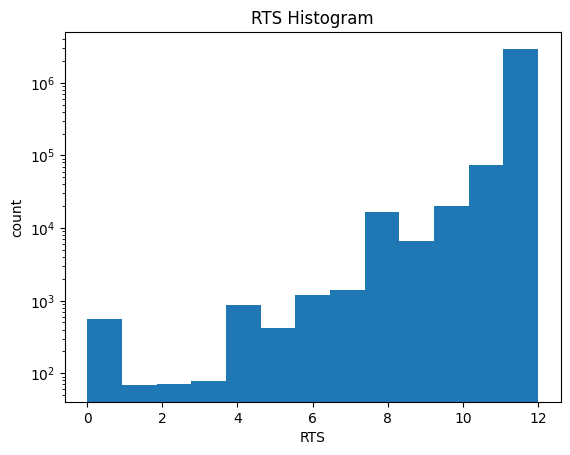

In [27]:
plt.hist(exclude2_denull_df['RTS'], 13, log=True)
plt.xlabel("RTS"); plt.ylabel("count"); plt.title("RTS Histogram")
plt.show()

In [28]:
RTS_thresh = 11
sig_trauma_idx = exclude2_denull_df['RTS'] <= RTS_thresh
exclude2_denull_sig_df = exclude2_denull_df[sig_trauma_idx]
print(f"# significant trauma: {len(exclude2_denull_sig_df)}")
print(f"# insiginficiant trauma: {len(exclude2_denull_df) - len(exclude2_denull_sig_df)}")

# significant trauma: 120947
# insiginficiant trauma: 3553548


In [30]:
# keep insiginificant injuries given low number of cases w/ RTS <= 11
exclude2_denull_df.to_csv('/Volumes/Research/GoldenHourData/InclusionCriteria/InclusionExclusionCriteria.csv', index=False)
# exclude2_denull_sig_df.to_csv('Data/InclusionCriteria/InclusionExclusionCriteria.xlsx', index=False)


### (remove) Filter: destination team pre-arrival team/activation


include 

4224003	Yes-Adult Trauma

4224011	Yes-Pediatric Trauma

4224017	Yes-Trauma (General)

In [32]:
# edisposition.16, 
destination_df, _ = pyreadstat.read_sas7bdat('/Volumes/Research/GoldenHourData/NEMSISRawFiles/factpcrdestinationteam.sas7bdat')

In [33]:
# find counts of activation team
print(f"# of null activation data: {destination_df['eDisposition_24'].isnull().sum()}")

# desitnation_count = destination_df['eDisposition_24'].value_counts()
desitnation_count = destination_df['eDisposition_24'].value_counts(normalize=True) * 100
index_map = {
    "4224001":"No",
    "4224003":"Yes-Adult Trauma",
    "4224005":"Yes-Cardiac Arrest",
    "4224007":"Yes-Obstetrics",
    "4224009":"Yes-Other",
    "4224011":"Yes-Pediatric Trauma",
    "4224013":"Yes-STEMI",
    "4224015":"Yes-Stroke",
    "4224017":"Yes-Trauma (General)",
    "4224019":"Yes-Sepsis",
    "7701001":"Not Recorded",
    "7701003":"Not Applicable",
}

# Rename the index using the dictionary
desitnation_count.rename(index=index_map, inplace=True)

desitnation_count


# of null activation data: 0


eDisposition_24
Not Applicable          45.571912
No                      33.234821
Not Recorded            17.884057
Yes-Other                1.797871
Yes-Stroke               0.497194
Yes-Adult Trauma         0.397424
Yes-Trauma (General)     0.336292
Yes-STEMI                0.137168
Yes-Cardiac Arrest       0.098143
Yes-Pediatric Trauma     0.033337
Yes-Obstetrics           0.011780
Name: proportion, dtype: float64

In [34]:
desired_team_idx = destination_df['eDisposition_24'].isin(['4224003', '4224011', '4224017'])

# 1 point for meeting 1 activatin team called
destination_df['desired_team'] = 0
destination_df.loc[desired_team_idx, 'desired_team'] = 1

In [35]:
# sum how many desired team activation, use this to filter for desired pcrkey
destination_deduped_df = destination_df.groupby('PcrKey').agg({'desired_team': 'sum', 'eDisposition_24': 'first'})
destination_deduped_df = destination_deduped_df.reset_index()


In [36]:
# merge disposition data to filtered trauma data
trauma_dispo_adt_dest_df = trauma_dispo_adt_df.merge(destination_deduped_df, left_on='PcrKey', right_on='PcrKey', how='left', validate='1:1')


In [37]:
# filter for only desired activation team
trauma_dispo_adtAt_df = trauma_dispo_adt_dest_df[trauma_dispo_adt_dest_df['desired_team'] > 0]

print(f"# cases w/o desired activation team: {len(trauma_dispo_adt_dest_df) - len(trauma_dispo_adtAt_df)}")
print(f"# cases w/ desired activation team: {len(trauma_dispo_adtAt_df)}")

trauma_dispo_adtAt_df.sample()

# cases w/o desired activation team: 3392630
# cases w/ desired activation team: 281865


,PcrKey,eDisposition_16,eDisposition_21,ePatient_15,transport_method,desired_team,eDisposition_24
3444927,250529360.0,4216005,4221003,26.0,ground,1,4224003


In [41]:
trauma_dispo_adtAt_df.to_excel('/Volumes/Research/GoldenHourData/InclusionCriteria/InclusionCriteriaData.xlsx', index=False)

### mortality and transportation data